# 1. MVP de Análise de Dados e Boas Práticas

## Disciplina: Sprint: Análise de Dados e Boas Práticas

Aluno: Arthur William Cardoso Santos

## 1. Definição do Problema

Para o MVP do módulo 1, vamos utilizar os dados do SINASC (Sistema de Informação sobre Nascidos Vivos) do DATASUS através de API da PCDaS (Plataforma de Ciência de Dados Aplicada à Saúde) https://pcdas.icict.fiocruz.br/ da Fiocruz, a qual funciona como Platform-as-a-Service (PaaS).

O SINASC é um sistema que reúne informações de todos os partos ocorridos no Brasil desde 1996. Não há missings, pois o preenchimento de todos os campos é obrigatório, porém há dados inconsistentes como, por exemplo, parturientes com 99 anos, por exemplo, situação já relatada em reportagens jornalísticas e artigos científicos.

## 1.1 Dicionário de variáveis

nasc_SIGLA_UF: Sigla da unidade da federação de nascimento

res_SIGLA_UF: Sigla da unidade da federação de residência

ano_nasc: Ano do nascimento

data_nasc: Data de nascimento

DTNASC: Data do nascimento, no formato ddmmaaaa

nasc_MUNNOME: Nome do município de nascimento

res_MUNNOME: Nome do município de residência

dia_semana_nasc: Dia da semana em que ocorreu o nascimento (dom; seg; ter; qua; qui; sex; sáb)

HORANASC: Horário de nascimento

def_parto: Tipo de parto (Nominal, com as seguintes classificações: Vaginal; Cesáreo; Ignorado)

def_raca_cor: Raça/cor (Nominal, com as seguintes classificações: Branca; Preta; Amarela; Parda; Indígena)

PESO: Peso ao nascer, em gramas

IDADEMAE: Idade da mãe em anos

IDADEPAI: Idade do pai

SEMAGESTAC: Número de semanas de gestação

CONSPRENAT: Número de consultas pré‐natal

MESPRENAT: Mês de gestação em que iniciou o pré‐natal

def_loc_nasc: Local de nascimento (Nominal, com as seguintes classificações: Hospital; Outros estabelecimentos de saúde; Domicílio; Via pública; Outros; Ignorado)

APGAR1: Apgar no primeiro minuto 00 a 10

APGAR5: Apgar no quinto minuto 00 a 10

QTDFILVIVO: Número de filhos vivos

QTDFILMORT: Número de filhos mortos

QTDGESTANT: Número de gestações anteriores

QTDPARTNOR: Número de partos vaginais

QTDPARTCES: 	Número de partos cesáreos



In [ ]:
# Imports
%matplotlib inline
import requests
import os
import json
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms # para tratamento de missings
from matplotlib import cm
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
# import elasticsearch
sns.set()

In [ ]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

## 2. Carga de Dados

Esta célula tem como finalidade armazenar a credencial de acesso ao PCDaS (token 'f7ffadc6e12ca72a3014530fe2e91ece5bb3c4a2') para ser utilizada nas etapas seguintes

In [ ]:
from IPython.display import clear_output
import getpass

token = "f7ffadc6e12ca72a3014530fe2e91ece5bb3c4a2"

clear_output()

URL por onde os dados serão acessados via API

In [ ]:
url_base = "https://bigdata-api.fiocruz.br"

Verificar se o usuário tem acesso database do SINASC está disponível pela API.

In [ ]:
params = {
          "token": token
        }
resp = requests.post(url_base+ '/show_tables', json=params)
print(resp.json())

{'databases': ['datasus-sim', 'datasus-sinasc', 'datasus-sih', 'datasus-pop', 'datasus-cnes', 'datasus-sim-dofet']}


Verificar os anos de que o sistema possui dados de nascimento.

In [ ]:
%time

params =  {
          "token": {
            "token": token
          },
          "atributo": {
            "index": "datasus-sinasc",
            "limit": 100,
            "atributo": "ano_nasc"
          },
          "query": {
            "query_string": {}
          }
        }
resp = requests.post(os.path.join(url_base,'agg_by_field'), json=params)

df_sinasc = pd.DataFrame(json.loads(resp.content))
df_sinasc.columns = ['UF','ano']
df_sinasc

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


,UF,ano
0,1996,2945425
1,1997,3026658
2,1998,3148037
3,1999,3256433
4,2000,3206761
5,2001,3115474
6,2002,3059402
7,2003,3038251
8,2004,3026548
9,2005,3035096


Agora vamos, calcular a quantidade de partos totais registradas do banco de dados do SINASC desde 1996.

In [ ]:
soma_ano = df_sinasc['ano'].sum()
print("Quantidade de partos:", soma_ano)

Quantidade de partos: 77075180


Agora vamos verificar uma informação muito falada pela literatura científica de que há um dado inconsistente no preenchimento do SINASC. Como todos os campos são obrigatórios, mais de uma centena de milhares de vezes a idade da parturiente foi sinalizada como 99, indicando que 99 é sinônimo de missing, situação cuja correção será realizada em etapa posterior.

In [ ]:
%time

params =  {
          "token": {
            "token": token
          },
          "atributo": {
            "index": "datasus-sinasc",
            "limit": 120,
            "atributo": "IDADEMAE"
          },
          "query": {
            "query_string": {}
          }
        }
resp = requests.post(os.path.join(url_base,'agg_by_field'), json=params)

df_sinasc = pd.DataFrame(json.loads(resp.content))
df_sinasc.columns = ['UF','idade_mae']
df_sinasc

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


,UF,idade_mae
0,0.0,835
1,8.0,7
2,9.0,9
3,10.0,718
4,11.0,2959
5,12.0,19232
6,13.0,124519
7,14.0,523841
8,15.0,1317600
9,16.0,2291851


Como o SINASC possui mais de 77 milhões de registros, para este exercío vamos montar um data frame com informações do SINASC com uma amostra de nascimentos no Rio de Janeiro por parturtientes que residem em outro estado entre 1996 e 2021.

In [ ]:
%time
sql = {
          "token": {
            "token": token
          },
          "sql": {
            "sql": {"query":"SELECT nasc_SIGLA_UF, res_SIGLA_UF, ano_nasc, data_nasc, DTNASC, nasc_MUNNOME, res_MUNNOME, dia_semana_nasc, HORANASC, def_parto, def_raca_cor, PESO, IDADEMAE, IDADEPAI, SEMAGESTAC, CONSPRENAT, MESPRENAT, def_loc_nasc, APGAR1, APGAR5, QTDFILVIVO, QTDFILMORT, QTDGESTANT, QTDPARTNOR, QTDPARTCES  \
                    FROM \"datasus-sinasc\" \
                    WHERE nasc_SIGLA_UF = 'SP' AND res_SIGLA_UF != 'SP' \
                    GROUP BY nasc_SIGLA_UF, res_SIGLA_UF, ano_nasc, data_nasc, DTNASC, nasc_MUNNOME, res_MUNNOME, dia_semana_nasc, HORANASC, def_parto, def_raca_cor, PESO, IDADEMAE, IDADEPAI, SEMAGESTAC, CONSPRENAT, MESPRENAT, def_loc_nasc, APGAR1, APGAR5, QTDFILVIVO, QTDFILMORT, QTDGESTANT, QTDPARTNOR, QTDPARTCES ",
                    "fetch_size":65535
                   }
          }
        }
resp = requests.post(os.path.join(url_base,'sql_query'), json=sql)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


Aqui, implementamos um função que tem como objetivo converter a resposta da API, no formato tabular conhecido como: dataframe

In [ ]:
def json_to_df(resp):
    columns = [col['name'] for col in resp.json()['columns']]
    values = resp.json()['rows']

    return pd.DataFrame(values, columns=columns)

In [ ]:
response_data = resp.json()

Nomeamos o dataframe obtido de df_sinasc

In [ ]:
df_sinasc = json_to_df(resp)

## 3. Análise de Dados

### 3.1. Estatísticas Descritivas

Vamos iniciar examinando as dimensões do dataset, suas informações e alguns exemplos de linhas. A amostra possui 40.386 partos entre 1966 e 2021.

In [ ]:
# Mostra as dimensões do dataset
print(df_sinasc.shape)

(40387, 25)


Listar as categorias presentes no dataframe:

In [ ]:
# exibindo os nomes das colunas
df_sinasc.columns

Index(['nasc_SIGLA_UF', 'res_SIGLA_UF', 'ano_nasc', 'data_nasc', 'DTNASC',
       'nasc_MUNNOME', 'res_MUNNOME', 'dia_semana_nasc', 'HORANASC',
       'def_parto', 'def_raca_cor', 'PESO', 'IDADEMAE', 'IDADEPAI',
       'SEMAGESTAC', 'CONSPRENAT', 'MESPRENAT', 'def_loc_nasc', 'APGAR1',
       'APGAR5', 'QTDFILVIVO', 'QTDFILMORT', 'QTDGESTANT', 'QTDPARTNOR',
       'QTDPARTCES'],
      dtype='object')

In [ ]:
# exibindo a quantidade de linhas por coluna
df_sinasc.count()

nasc_SIGLA_UF      40387
res_SIGLA_UF       40387
ano_nasc           40387
data_nasc          38923
DTNASC             40387
nasc_MUNNOME       40387
res_MUNNOME        40387
dia_semana_nasc    38923
HORANASC           29840
def_parto          40387
def_raca_cor       40387
PESO               40236
IDADEMAE           40353
IDADEPAI           16894
SEMAGESTAC         20431
CONSPRENAT         18398
MESPRENAT          20275
def_loc_nasc       40387
APGAR1             38021
APGAR5             38002
QTDFILVIVO         37284
QTDFILMORT         35861
QTDGESTANT         20284
QTDPARTNOR         20214
QTDPARTCES         20263
dtype: int64

In [ ]:
# Mostra as informações do dataset
print(df_sinasc.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40387 entries, 0 to 40386
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   nasc_SIGLA_UF    40387 non-null  object 
 1   res_SIGLA_UF     40387 non-null  object 
 2   ano_nasc         40387 non-null  int64  
 3   data_nasc        38923 non-null  object 
 4   DTNASC           40387 non-null  object 
 5   nasc_MUNNOME     40387 non-null  object 
 6   res_MUNNOME      40387 non-null  object 
 7   dia_semana_nasc  38923 non-null  object 
 8   HORANASC         29840 non-null  object 
 9   def_parto        40387 non-null  object 
 10  def_raca_cor     40387 non-null  object 
 11  PESO             40236 non-null  float64
 12  IDADEMAE         40353 non-null  float64
 13  IDADEPAI         16894 non-null  float64
 14  SEMAGESTAC       20431 non-null  float64
 15  CONSPRENAT       18398 non-null  float64
 16  MESPRENAT        20275 non-null  float64
 17  def_loc_nasc

In [ ]:
# Mostra as 10 primeiras linhas do dataset
df_sinasc.head(10)

,nasc_SIGLA_UF,res_SIGLA_UF,ano_nasc,data_nasc,DTNASC,nasc_MUNNOME,res_MUNNOME,dia_semana_nasc,HORANASC,def_parto,...,CONSPRENAT,MESPRENAT,def_loc_nasc,APGAR1,APGAR5,QTDFILVIVO,QTDFILMORT,QTDGESTANT,QTDPARTNOR,QTDPARTCES
0,SP,AC,1998,1998-02-22T00:00:00.000Z,22021998,Fernandópolis,Rio Branco,dom,None,Cesáreo,...,NaN,NaN,Hospital,08,10,NaN,NaN,NaN,NaN,NaN
1,SP,AC,1998,1998-06-11T00:00:00.000Z,11061998,Presidente Prudente,Rio Branco,qui,None,Cesáreo,...,NaN,NaN,Hospital,08,09,0.0,0.0,NaN,NaN,NaN
2,SP,AC,2001,2001-06-07T00:00:00.000Z,07062001,Campinas,Rio Branco,qui,None,Cesáreo,...,NaN,NaN,Hospital,09,10,0.0,0.0,NaN,NaN,NaN
3,SP,AC,2003,2003-09-29T00:00:00.000Z,29092003,Campinas,Rio Branco,seg,None,Cesáreo,...,NaN,NaN,Hospital,07,09,1.0,0.0,NaN,NaN,NaN
4,SP,AC,2005,2005-07-04T00:00:00.000Z,04072005,São Paulo,Rio Branco,seg,None,Cesáreo,...,NaN,NaN,Hospital,09,10,1.0,0.0,NaN,NaN,NaN
5,SP,AC,2005,2005-08-23T00:00:00.000Z,23082005,São Paulo,Rio Branco,ter,None,Vaginal,...,NaN,NaN,Hospital,09,10,0.0,0.0,NaN,NaN,NaN
6,SP,AC,2006,2006-06-22T00:00:00.000Z,22062006,São Paulo,Epitaciolândia,qui,1238,Cesáreo,...,NaN,NaN,Hospital,09,10,1.0,0.0,NaN,NaN,NaN
7,SP,AC,2006,2006-11-21T00:00:00.000Z,21112006,São Paulo,Rio Branco,ter,1451,Cesáreo,...,NaN,NaN,Hospital,09,10,0.0,0.0,NaN,NaN,NaN
8,SP,AC,2006,2006-11-23T00:00:00.000Z,23112006,São Paulo,Rio Branco,qui,0124,Cesáreo,...,NaN,NaN,Hospital,09,10,0.0,0.0,NaN,NaN,NaN
9,SP,AC,2009,2009-09-22T00:00:00.000Z,22092009,São José do Rio Preto,Rio Branco,ter,1904,Cesáreo,...,NaN,NaN,Hospital,08,10,0.0,1.0,NaN,NaN,NaN


In [ ]:
# Mostra as 10 últimas linhas do dataset
df_sinasc.tail(10)

,nasc_SIGLA_UF,res_SIGLA_UF,ano_nasc,data_nasc,DTNASC,nasc_MUNNOME,res_MUNNOME,dia_semana_nasc,HORANASC,def_parto,...,CONSPRENAT,MESPRENAT,def_loc_nasc,APGAR1,APGAR5,QTDFILVIVO,QTDFILMORT,QTDGESTANT,QTDPARTNOR,QTDPARTCES
40377,SP,TO,2020,2020-03-28T00:00:00.000Z,28032020,Fernandópolis,Campos Lindos,sab,1950,Cesáreo,...,7.0,2.0,Hospital,09,10,2.0,0.0,2.0,2.0,0.0
40378,SP,TO,2020,2020-04-20T00:00:00.000Z,20042020,São Paulo,Caseara,seg,0918,Cesáreo,...,8.0,1.0,Hospital,04,06,0.0,0.0,0.0,0.0,0.0
40379,SP,TO,2020,2020-09-11T00:00:00.000Z,11092020,São Paulo,Araguaína,sex,1433,Cesáreo,...,10.0,1.0,Hospital,09,10,1.0,0.0,1.0,0.0,1.0
40380,SP,TO,2020,2020-10-01T00:00:00.000Z,01102020,São Paulo,Palmas,qui,2107,Cesáreo,...,5.0,6.0,Hospital,08,08,0.0,0.0,0.0,0.0,0.0
40381,SP,TO,2020,2020-12-20T00:00:00.000Z,20122020,São Paulo,Araguaína,dom,1428,Cesáreo,...,9.0,2.0,Hospital,09,10,1.0,0.0,1.0,0.0,1.0
40382,SP,TO,2021,2021-01-01T00:00:00.000Z,01012021,São Paulo,Araguaína,sex,1403,Cesáreo,...,5.0,1.0,Hospital,03,04,1.0,0.0,1.0,0.0,1.0
40383,SP,TO,2021,2021-02-18T00:00:00.000Z,18022021,São Paulo,Palmas,qui,1857,Cesáreo,...,10.0,1.0,Hospital,05,09,0.0,1.0,1.0,0.0,0.0
40384,SP,TO,2021,2021-09-18T00:00:00.000Z,18092021,Campinas,Araguaína,sab,1106,Cesáreo,...,3.0,7.0,Hospital,09,10,0.0,0.0,0.0,0.0,0.0
40385,SP,TO,2021,2021-10-13T00:00:00.000Z,13102021,São Paulo,Araguaína,qua,1213,Cesáreo,...,15.0,1.0,Hospital,09,10,1.0,0.0,1.0,0.0,1.0
40386,SP,TO,2021,2021-10-30T00:00:00.000Z,30102021,Campinas,Araguaína,sab,1842,Vaginal,...,9.0,2.0,Hospital,01,06,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Verifica o tipo de dataset de cada atributo
df_sinasc.dtypes

nasc_SIGLA_UF       object
res_SIGLA_UF        object
ano_nasc             int64
data_nasc           object
DTNASC              object
nasc_MUNNOME        object
res_MUNNOME         object
dia_semana_nasc     object
HORANASC            object
def_parto           object
def_raca_cor        object
PESO               float64
IDADEMAE           float64
IDADEPAI           float64
SEMAGESTAC         float64
CONSPRENAT         float64
MESPRENAT          float64
def_loc_nasc        object
APGAR1              object
APGAR5              object
QTDFILVIVO         float64
QTDFILMORT         float64
QTDGESTANT         float64
QTDPARTNOR         float64
QTDPARTCES         float64
dtype: object

In [ ]:
# Faz um resumo estatístico do dataset (média, desvio padrão, mínimo, máximo e os quartis)
df_sinasc.describe()

,ano_nasc,PESO,IDADEMAE,IDADEPAI,SEMAGESTAC,CONSPRENAT,MESPRENAT,QTDFILVIVO,QTDFILMORT,QTDGESTANT,QTDPARTNOR,QTDPARTCES
count,40387.000000,40236.000000,40353.000000,16894.000000,20431.000000,18398.000000,20275.000000,37284.000000,35861.000000,20284.000000,20214.000000,20263.000000
mean,2010.364771,3080.904439,28.042698,32.305079,37.759141,9.326557,3.980617,2.079927,2.546248,0.946707,0.303206,0.465824
std,7.406965,679.843987,7.415048,7.232380,2.380905,7.321458,13.517717,11.073145,15.136634,1.489489,1.278331,1.383949
min,1996.000000,0.000000,10.000000,15.000000,19.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2005.000000,2800.000000,23.000000,27.000000,37.000000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2012.000000,3140.000000,28.000000,32.000000,38.000000,9.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,2016.000000,3440.000000,33.000000,37.000000,39.000000,10.000000,3.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,2021.000000,9999.000000,99.000000,91.000000,45.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000


In [ ]:
# ordenando o dataframe por uma coluna
df_sinasc.sort_values(by='data_nasc')

,nasc_SIGLA_UF,res_SIGLA_UF,ano_nasc,data_nasc,DTNASC,nasc_MUNNOME,res_MUNNOME,dia_semana_nasc,HORANASC,def_parto,...,CONSPRENAT,MESPRENAT,def_loc_nasc,APGAR1,APGAR5,QTDFILVIVO,QTDFILMORT,QTDGESTANT,QTDPARTNOR,QTDPARTCES
30814,SP,PR,1996,1996-01-02T00:00:00.000Z,02011996,Palmital,Município ignorado - PR,ter,None,Vaginal,...,NaN,NaN,Hospital,09,10,2.0,1.0,NaN,NaN,NaN
22870,SP,MS,1996,1996-01-02T00:00:00.000Z,02011996,São José do Rio Preto,Paranaíba,ter,None,Vaginal,...,NaN,NaN,Hospital,08,09,3.0,1.0,NaN,NaN,NaN
3220,SP,MG,1996,1996-01-03T00:00:00.000Z,03011996,São Bento do Sapucaí,Conceição dos Ouros,qua,None,Vaginal,...,NaN,NaN,Hospital,None,None,NaN,NaN,NaN,NaN,NaN
22871,SP,MS,1996,1996-01-03T00:00:00.000Z,03011996,Santa Fé do Sul,Inocência,qua,None,Vaginal,...,NaN,NaN,Hospital,06,10,NaN,NaN,NaN,NaN,NaN
3218,SP,MG,1996,1996-01-03T00:00:00.000Z,03011996,Bragança Paulista,Munhoz,qua,None,Ignorado,...,NaN,NaN,Hospital,None,None,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40278,SP,TO,1996,None,00001996,São Paulo,Cachoeirinha,None,None,Vaginal,...,NaN,NaN,Ignorado,None,None,NaN,NaN,NaN,NaN,NaN
40279,SP,TO,1996,None,00001996,São Paulo,Cachoeirinha,None,None,Vaginal,...,NaN,NaN,Ignorado,None,None,NaN,NaN,NaN,NaN,NaN
40280,SP,TO,1996,None,00001996,São Paulo,Monte do Carmo,None,None,Cesáreo,...,NaN,NaN,Ignorado,None,None,NaN,NaN,NaN,NaN,NaN
40281,SP,TO,1996,None,00001996,São Paulo,Município ignorado - TO,None,None,Ignorado,...,NaN,NaN,Ignorado,None,None,NaN,NaN,NaN,NaN,NaN


In [ ]:
# ordenando por uma coluna de ordem descendente
df_sinasc.sort_values(by='data_nasc', ascending=False)

,nasc_SIGLA_UF,res_SIGLA_UF,ano_nasc,data_nasc,DTNASC,nasc_MUNNOME,res_MUNNOME,dia_semana_nasc,HORANASC,def_parto,...,CONSPRENAT,MESPRENAT,def_loc_nasc,APGAR1,APGAR5,QTDFILVIVO,QTDFILMORT,QTDGESTANT,QTDPARTNOR,QTDPARTCES
2627,SP,GO,2021,2021-12-31T00:00:00.000Z,31122021,Guaíra,Caldas Novas,sex,1527,Cesáreo,...,12.0,1.0,Hospital,10,10,0.0,0.0,0.0,0.0,0.0
22755,SP,MG,2021,2021-12-30T00:00:00.000Z,30122021,Atibaia,Extrema,qui,1616,Cesáreo,...,10.0,3.0,Hospital,08,10,0.0,0.0,0.0,0.0,0.0
22756,SP,MG,2021,2021-12-30T00:00:00.000Z,30122021,São Paulo,Boa Esperança,qui,1011,Cesáreo,...,10.0,2.0,Hospital,08,09,0.0,0.0,0.0,0.0,0.0
37915,SP,PR,2021,2021-12-30T00:00:00.000Z,30122021,Itararé,Sengés,qui,1431,Cesáreo,...,9.0,2.0,Hospital,09,10,1.0,0.0,1.0,0.0,1.0
22754,SP,MG,2021,2021-12-29T00:00:00.000Z,29122021,São José dos Campos,Sapucaí-Mirim,qua,1957,Cesáreo,...,9.0,1.0,Hospital,09,09,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40278,SP,TO,1996,None,00001996,São Paulo,Cachoeirinha,None,None,Vaginal,...,NaN,NaN,Ignorado,None,None,NaN,NaN,NaN,NaN,NaN
40279,SP,TO,1996,None,00001996,São Paulo,Cachoeirinha,None,None,Vaginal,...,NaN,NaN,Ignorado,None,None,NaN,NaN,NaN,NaN,NaN
40280,SP,TO,1996,None,00001996,São Paulo,Monte do Carmo,None,None,Cesáreo,...,NaN,NaN,Ignorado,None,None,NaN,NaN,NaN,NaN,NaN
40281,SP,TO,1996,None,00001996,São Paulo,Município ignorado - TO,None,None,Ignorado,...,NaN,NaN,Ignorado,None,None,NaN,NaN,NaN,NaN,NaN


In [ ]:
# selecionando linhas segundo um critério
df_sinasc[df_sinasc['ano_nasc'] == 2020]

,nasc_SIGLA_UF,res_SIGLA_UF,ano_nasc,data_nasc,DTNASC,nasc_MUNNOME,res_MUNNOME,dia_semana_nasc,HORANASC,def_parto,...,CONSPRENAT,MESPRENAT,def_loc_nasc,APGAR1,APGAR5,QTDFILVIVO,QTDFILMORT,QTDGESTANT,QTDPARTNOR,QTDPARTCES
34,SP,AC,2020,2020-04-06T00:00:00.000Z,06042020,São Caetano do Sul,Rio Branco,seg,0956,Cesáreo,...,6.0,2.0,Hospital,09,09,0.0,1.0,1.0,0.0,0.0
35,SP,AC,2020,2020-12-21T00:00:00.000Z,21122020,São Paulo,Rio Branco,seg,1100,Cesáreo,...,12.0,1.0,Hospital,09,10,1.0,2.0,3.0,0.0,1.0
210,SP,AL,2020,2020-03-30T00:00:00.000Z,30032020,Catanduva,Santana do Ipanema,seg,0313,Vaginal,...,11.0,2.0,Hospital,10,10,0.0,0.0,0.0,0.0,0.0
211,SP,AL,2020,2020-04-25T00:00:00.000Z,25042020,Campinas,Inhapi,sab,0906,Cesáreo,...,11.0,1.0,Hospital,08,10,3.0,1.0,4.0,1.0,2.0
212,SP,AL,2020,2020-04-28T00:00:00.000Z,28042020,Limeira,Teotônio Vilela,ter,1114,Cesáreo,...,12.0,1.0,Hospital,09,10,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40377,SP,TO,2020,2020-03-28T00:00:00.000Z,28032020,Fernandópolis,Campos Lindos,sab,1950,Cesáreo,...,7.0,2.0,Hospital,09,10,2.0,0.0,2.0,2.0,0.0
40378,SP,TO,2020,2020-04-20T00:00:00.000Z,20042020,São Paulo,Caseara,seg,0918,Cesáreo,...,8.0,1.0,Hospital,04,06,0.0,0.0,0.0,0.0,0.0
40379,SP,TO,2020,2020-09-11T00:00:00.000Z,11092020,São Paulo,Araguaína,sex,1433,Cesáreo,...,10.0,1.0,Hospital,09,10,1.0,0.0,1.0,0.0,1.0
40380,SP,TO,2020,2020-10-01T00:00:00.000Z,01102020,São Paulo,Palmas,qui,2107,Cesáreo,...,5.0,6.0,Hospital,08,08,0.0,0.0,0.0,0.0,0.0


In [ ]:
# exibindo a mediana de cada atributo, agrupado por ano de nascimento
df_sinasc.groupby('ano_nasc').median()

,PESO,IDADEMAE,IDADEPAI,SEMAGESTAC,CONSPRENAT,MESPRENAT,QTDFILVIVO,QTDFILMORT,QTDGESTANT,QTDPARTNOR,QTDPARTCES
ano_nasc,,,,,,,,,,,
1996,3200.0,24.0,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN
1997,3110.0,25.0,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN
1998,3125.0,25.0,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN
1999,3155.0,24.0,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN
2000,3150.0,25.0,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN
2001,3150.0,26.0,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN
2002,3150.0,26.0,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN
2003,3170.0,26.0,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN
2004,3100.0,27.0,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN


Calcular a medidiana de cada atributo a partir da categoria "def_parto":

In [ ]:
df_sinasc.groupby('def_parto').mean()

,ano_nasc,PESO,IDADEMAE,IDADEPAI,SEMAGESTAC,CONSPRENAT,MESPRENAT,QTDFILVIVO,QTDFILMORT,QTDGESTANT,QTDPARTNOR,QTDPARTCES
def_parto,,,,,,,,,,,,
Cesáreo,2011.629516,3078.285794,28.737710,32.533598,37.767079,9.347672,3.546215,1.883296,2.317022,0.917604,0.212846,0.523216
Ignorado,1999.018349,5401.770833,29.401961,22.500000,37.000000,7.333333,26.750000,36.709677,41.476744,1.000000,0.500000,0.500000
Vaginal,2006.599854,3054.351571,25.800625,30.836500,37.713123,9.202431,6.522541,2.374985,2.945834,1.117667,0.832880,0.128101


Calcular a medidiana de cada atributo a partir da categoria "dia_semana_nasc":

In [ ]:
df_sinasc.groupby('dia_semana_nasc').mean()

,ano_nasc,PESO,IDADEMAE,IDADEPAI,SEMAGESTAC,CONSPRENAT,MESPRENAT,QTDFILVIVO,QTDFILMORT,QTDGESTANT,QTDPARTNOR,QTDPARTCES
dia_semana_nasc,,,,,,,,,,,,
dom,2009.638397,3004.012441,27.422742,32.064126,37.398678,9.082060,4.126106,2.372660,3.123845,1.011756,0.427099,0.388235
qua,2011.473354,3090.378760,28.086937,32.126132,37.807556,9.213429,3.862912,1.939723,2.297230,0.939978,0.292380,0.455672
qui,2010.956910,3069.383743,28.227572,32.398058,37.742401,9.407594,4.098821,2.291809,2.701855,0.920520,0.268589,0.462004
sab,2010.094975,3007.425537,28.037475,32.048217,37.454689,9.363046,4.333333,2.296805,2.832410,0.928004,0.296336,0.425847
seg,2011.157538,3111.923193,28.485843,32.719762,37.914412,9.528423,4.119511,1.913582,2.387965,0.962891,0.300336,0.501814
sex,2010.982490,3086.222837,28.093431,32.148664,37.804825,9.332527,3.854874,1.944435,2.647028,0.913788,0.279550,0.433874
ter,2011.036966,3073.439072,28.252572,32.342795,37.830416,9.226206,3.699725,2.044519,2.266481,0.978762,0.328763,0.527803


Verificar a quantidade de partos por tipo, dado sobre qual faremos gráficos a seguir:

In [ ]:
# Verifica a distribuição das classes
df_sinasc.groupby('def_parto').size()

def_parto
Cesáreo     30560
Ignorado      218
Vaginal      9609
dtype: int64

Verificar a quantidade de partos por dia da semana, dado sobre qual faremos gráficos a seguir:

In [ ]:
# Verifica a distribuição das classes
df_sinasc.groupby('dia_semana_nasc').size()

dia_semana_nasc
dom    2995
qua    6530
qui    6382
sab    3980
seg    6646
sex    6168
ter    6222
dtype: int64

Verificar a quantidade de partos por ano, dado sobre qual faremos gráficos a seguir:

In [ ]:
# Verifica a distribuição das classes
df_sinasc.groupby('ano_nasc').size()

ano_nasc
1996    2201
1997    1352
1998     734
1999     726
2000    1064
2001     858
2002     635
2003     710
2004     696
2005    1529
2006    1428
2007    1390
2008    1557
2009    1481
2010    1503
2011    1734
2012    1868
2013    2061
2014    2341
2015    2288
2016    2180
2017    2162
2018    2274
2019    2118
2020    1766
2021    1731
dtype: int64

In [ ]:
# Correlação de Pearson
df_sinasc.corr(method = 'pearson')

,ano_nasc,PESO,IDADEMAE,IDADEPAI,SEMAGESTAC,CONSPRENAT,MESPRENAT,QTDFILVIVO,QTDFILMORT,QTDGESTANT,QTDPARTNOR,QTDPARTCES
ano_nasc,1.000000,-0.051354,0.144882,0.074790,-0.011360,-0.026125,-0.066342,-0.121684,-0.158012,-0.013385,-0.051863,0.005565
PESO,-0.051354,1.000000,0.008097,0.004005,0.662504,0.022746,-0.043505,0.005836,0.002809,0.014400,-0.003119,0.011912
IDADEMAE,0.144882,0.008097,1.000000,0.627387,-0.070189,0.049142,-0.029991,-0.033579,-0.052209,0.233428,0.070523,0.116571
IDADEPAI,0.074790,0.004005,0.627387,1.000000,-0.038701,0.027597,-0.015026,0.173325,0.057291,0.203861,0.075932,0.097797
SEMAGESTAC,-0.011360,0.662504,-0.070189,-0.038701,1.000000,0.030745,-0.049462,0.014449,-0.023172,-0.015662,0.020661,0.001287
CONSPRENAT,-0.026125,0.022746,0.049142,0.027597,0.030745,1.000000,0.337785,-0.017261,0.005471,-0.011917,-0.013289,-0.008402
MESPRENAT,-0.066342,-0.043505,-0.029991,-0.015026,-0.049462,0.337785,1.000000,0.030742,0.005530,0.029312,0.030902,0.003038
QTDFILVIVO,-0.121684,0.005836,-0.033579,0.173325,0.014449,-0.017261,0.030742,1.000000,0.715660,0.928954,0.853980,0.710944
QTDFILMORT,-0.158012,0.002809,-0.052209,0.057291,-0.023172,0.005471,0.005530,0.715660,1.000000,0.670191,0.603782,0.812646
QTDGESTANT,-0.013385,0.014400,0.233428,0.203861,-0.015662,-0.011917,0.029312,0.928954,0.670191,1.000000,0.804930,0.661679


### 3.2. Visualizações Unimodais

Gráfico a seguir mostra maior ocorrência de partos normais fora do horário comercial.

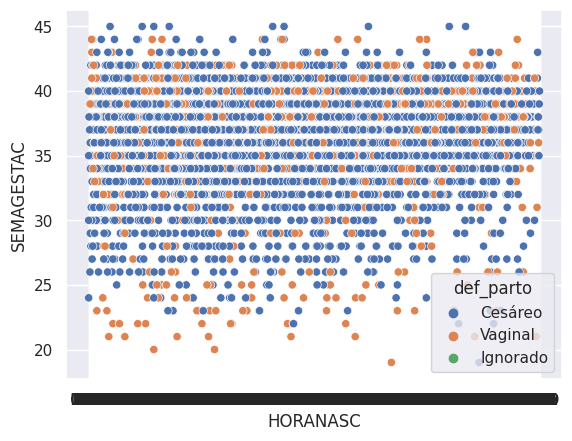

In [ ]:
# Selecionar apenas as colunas desejadas
df_filtered = df_sinasc[['HORANASC', 'SEMAGESTAC', 'def_parto']]

# scatter plot com Seaborn colorido por classes
sns.scatterplot(x='HORANASC', y='SEMAGESTAC', hue='def_parto', data=df_filtered);

O gráfico abaixo mostra apenas os partos de um sábado. Note que há menos partos cesáreos aos finais de semana.

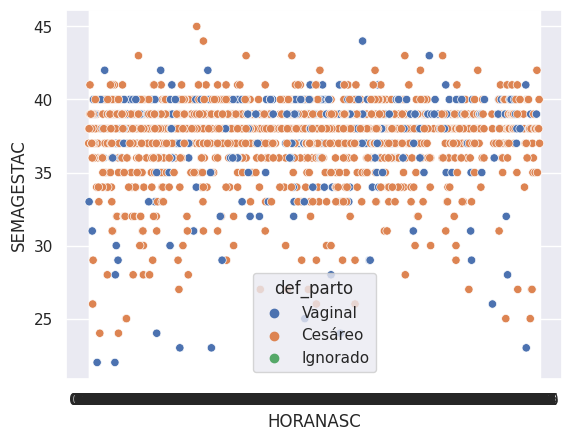

In [ ]:
# Selecionar apenas as colunas desejadas
df_filtered = df_sinasc[['HORANASC', 'SEMAGESTAC', 'def_parto', 'dia_semana_nasc']]

# Filtrar o DataFrame onde 'ano_nasc' é igual a dom
df_filtered = df_filtered[df_filtered['dia_semana_nasc'] == 'sab']

# scatter plot com Seaborn colorido por classes
sns.scatterplot(x='HORANASC', y='SEMAGESTAC', hue='def_parto', data=df_filtered);

Mostrar o percentual de partos por tipo:

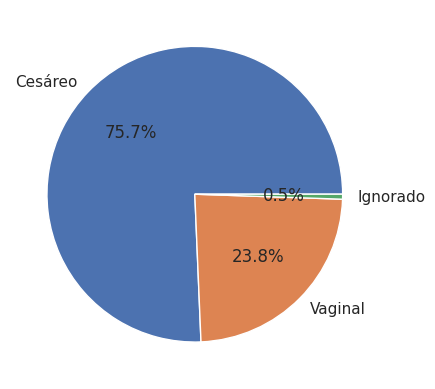

In [ ]:
import matplotlib.pyplot as plt

# Obtendo os valores categóricos únicos e a soma da quantidade de itens em cada categoria
categorias = df_sinasc['def_parto'].unique()
quantidade_por_categoria = df_sinasc['def_parto'].value_counts()

# Criando o gráfico de pizza com percentuais
plt.pie(quantidade_por_categoria, labels=categorias, autopct='%1.1f%%')
plt.show()

No gráfico abaixo, vemos a distribuição de tipo de parto pela cor de pele do bebê.

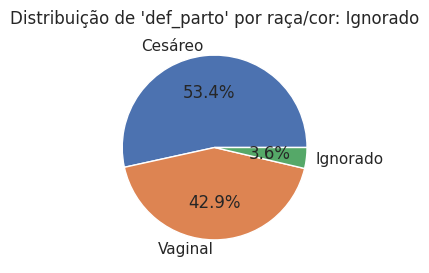

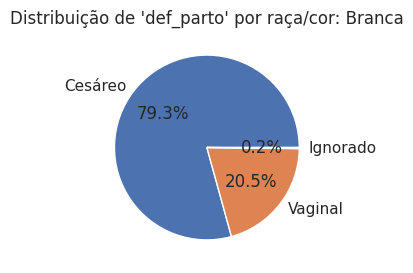

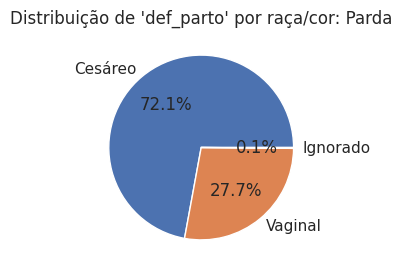

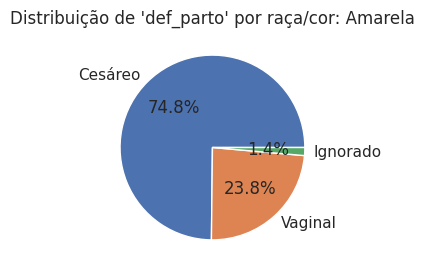

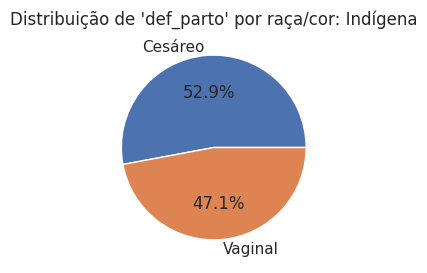

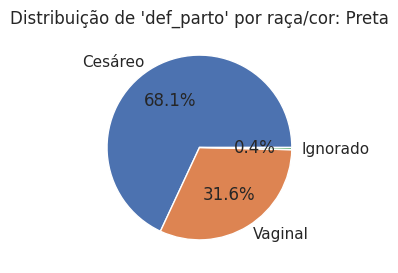

In [ ]:
# Identificando as categorias únicas na coluna 'def_raca_cor'
racas_cores = df_sinasc['def_raca_cor'].unique()

# Criando um gráfico de pizza para cada categoria de raça/cor
for raca_cor in racas_cores:
    # Filtrando o dataframe para a raça/cor atual
    df_filtrado = df_sinasc[df_sinasc['def_raca_cor'] == raca_cor]

    # Obtendo a distribuição de 'def_parto' para a raça/cor atual
    distribuicao = df_filtrado['def_parto'].value_counts()

    # Criando o gráfico de pizza
    plt.figure(figsize=(3, 3))  # Ajustando o tamanho do gráfico
    plt.pie(distribuicao, labels=distribuicao.index, autopct='%1.1f%%')
    plt.title(f"Distribuição de 'def_parto' por raça/cor: {raca_cor}")
    plt.show()



Note pelo gráfico abaixo que, aos finais de semana, há um percentual maior de partos naturais.

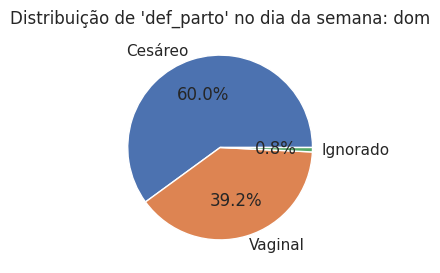

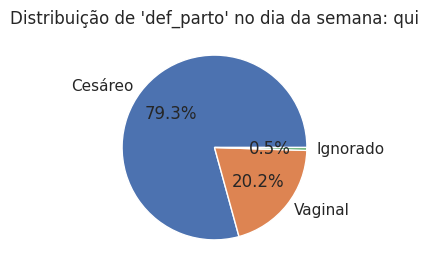

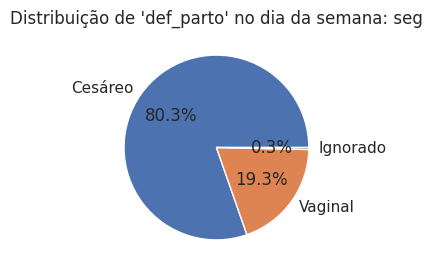

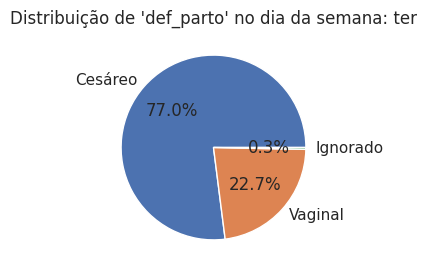

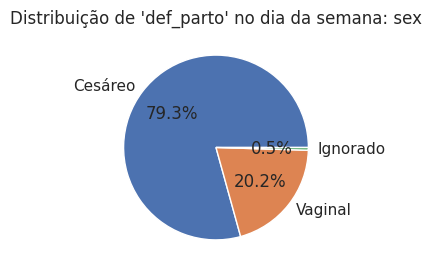

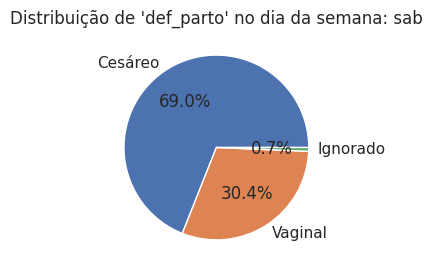

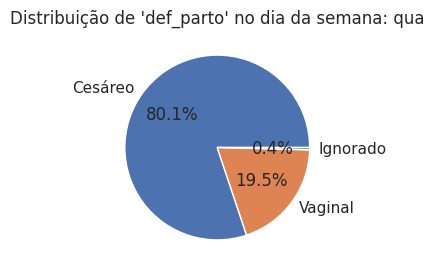

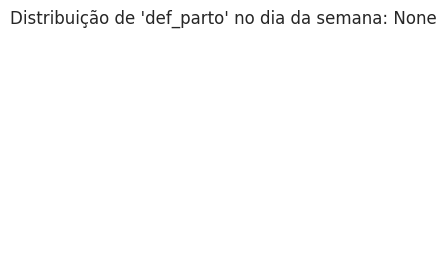

In [ ]:
# Identificando as categorias únicas na coluna 'dia_semana_nasc'
dias_semana = df_sinasc['dia_semana_nasc'].unique()

# Criando um gráfico de pizza para cada dia da semana
for dia in dias_semana:
    # Filtrando o dataframe para o dia da semana atual
    df_filtrado = df_sinasc[df_sinasc['dia_semana_nasc'] == dia]

    # Obtendo a distribuição de 'def_parto' para o dia da semana atual
    distribuicao = df_filtrado['def_parto'].value_counts()

    # Criando o gráfico de pizza
    plt.figure(figsize=(3, 3))  # Ajustando o tamanho do gráfico
    plt.pie(distribuicao, labels = distribuicao.index, autopct='%1.1f%%')
    plt.title(f"Distribuição de 'def_parto' no dia da semana: {dia}")
    plt.show()


Vamos criar agora um histograma para cada atributo do dataset. Veremos que os atributos age, pedi e test seguem uma distribuição exponencial, e que as colunas mass e press seguem uma distribuição aproximadamente normal.

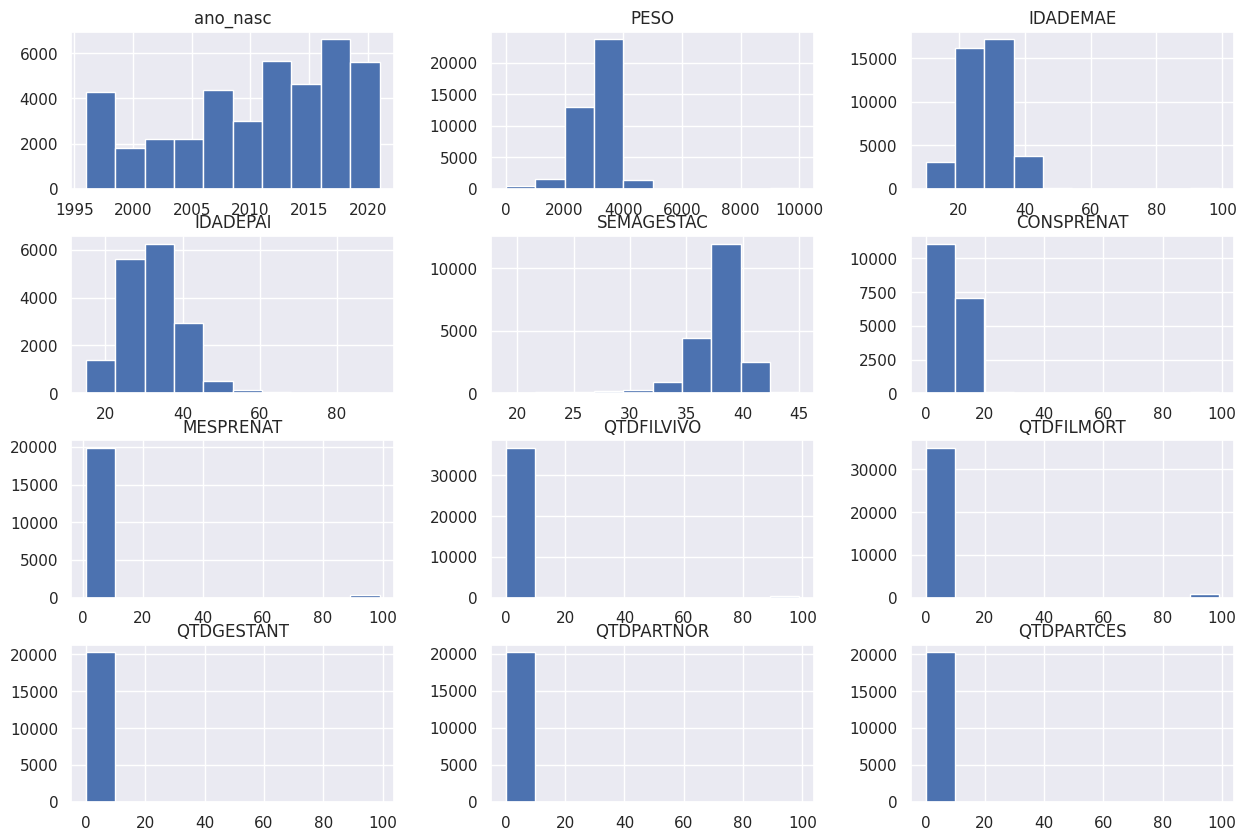

In [ ]:
# Histograma
df_sinasc.hist(figsize = (15,10))
plt.show()

O Gráfico de Densidade, ou Density Plot, é bem parecido com o histograma, mas com uma visualização um pouco diferente. Com ele, pode ser mais fácil identificar a distribuição do atributos do dataset. Assim como fizemos com o histograma, vamos criar um density plot para cada atributo do dataset.

Veremos que muitos dos atributos têm uma distribuição distorcida. Uma transformação como a Box-Cox, que pode aproximar a distribuição de uma Normal, pode ser útil neste caso.

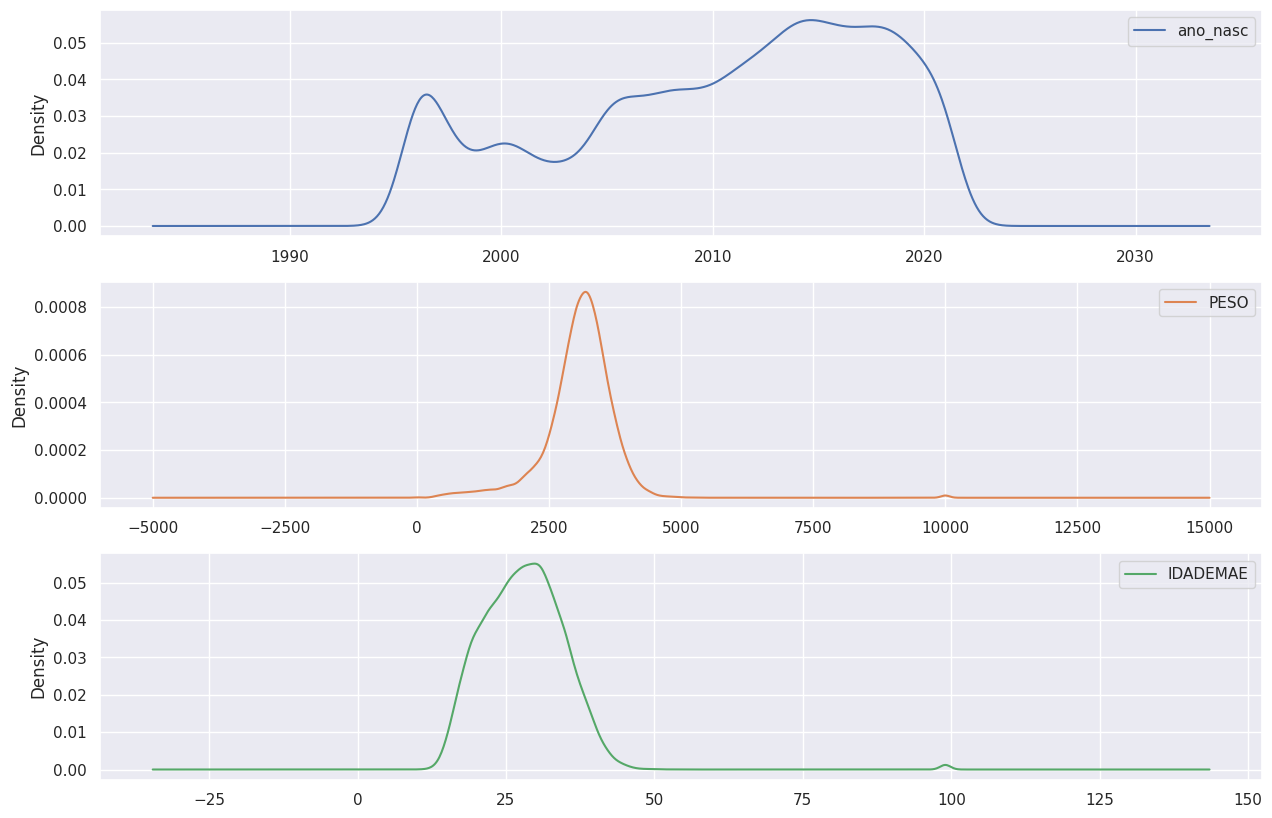

In [ ]:
# Selecionar apenas as colunas desejadas
df_filtered = df_sinasc[['ano_nasc', 'PESO', 'IDADEMAE']]

# Gerar gráficos de densidade para as colunas selecionadas
df_filtered.plot(kind='density', subplots=True, layout=(3, 1), sharex=False, figsize=(15, 10))
plt.show()

Vamos agora trabalhar com boxplots. No **boxblot**, a linha no centro (vermelha) representa o valor da mediana (segundo quartil ou p50). A linha abaixo é o 1o quartil (p25) e a linha acima o terceiro quartil (p75). O boxplot ajuda a ter uma ideia da dispersão dos dataset e os possíveis outliers.

*OBS: Se um ponto do dataset é muito distante da média (acima de 3 desvios padrão da média), pode ser considerado outlier.*

Nos gráficos bloxplot, veremos que a dispersão dos atributos do dataset é bem diferente.

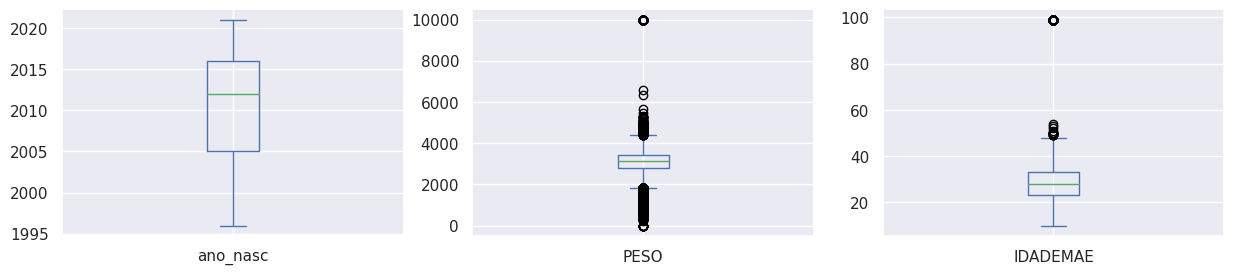

In [ ]:
# Selecionar apenas as colunas desejadas
df_filtered = df_sinasc[['ano_nasc', 'PESO', 'IDADEMAE']]

# Boxplot
df_filtered.plot(kind = 'box', subplots = True, layout = (3,3), sharex = False, sharey = False, figsize = (15,10))
plt.show()

### 3.3. Visualizações Multimodais

Ao visualizar as correlações entre os atributos através da matriz de correlação, perceberemos que parece haver alguma estrutura na ordem dos atributos. O azul ao redor da diagonal sugere que os atributos que estão próximos um do outro são geralmente mais correlacionados entre si. Os vermelhos também sugerem alguma correlação negativa moderada, a medida que os atributos

Vamos agora verificar a covariância entre as variáveis numéricas do dataset. A **covariância** representa como duas variáveis numéricas estão relacionadas. Existem várias formas de calcular a correlação entre duas variáveis, como por exemplo, o coeficiente de correlação de Pearson, que pode ser:
* Próximo de -1 : há uma correlação negativa entre as variáveis,
* Próximo de +1: há uma correlação positiva entre as variáveis.
* 0: não há correlação entre as variáveis.

<i>OBS: Esta informação é relevante porque alguns algoritmos como regressão linear e regressão logística podem apresentar problemas de performance se houver atributos altamente correlacionados. Vale a pena consultar a documentação do algoritmo para verificar se algum tipo de tratamento de dataset é necessário.</i>

Falamos anteriormente da importância da correlação entre os atributos, e agora iremos visualizar esta informação em formato gráfico. A **matriz de correlação** exibe graficamente a correlação entre os atributos numéricos do dataset.estão mais distantes um do outro na ordenação.

O código a seguir exibe a matriz de correlação.

Por sua vez, o gráfico de dispersão (scatter plot) mostra o relacionamento entre duas variáveis. Vamos exibir um para cada par de atributos dos dataset, usando o Seaborn.

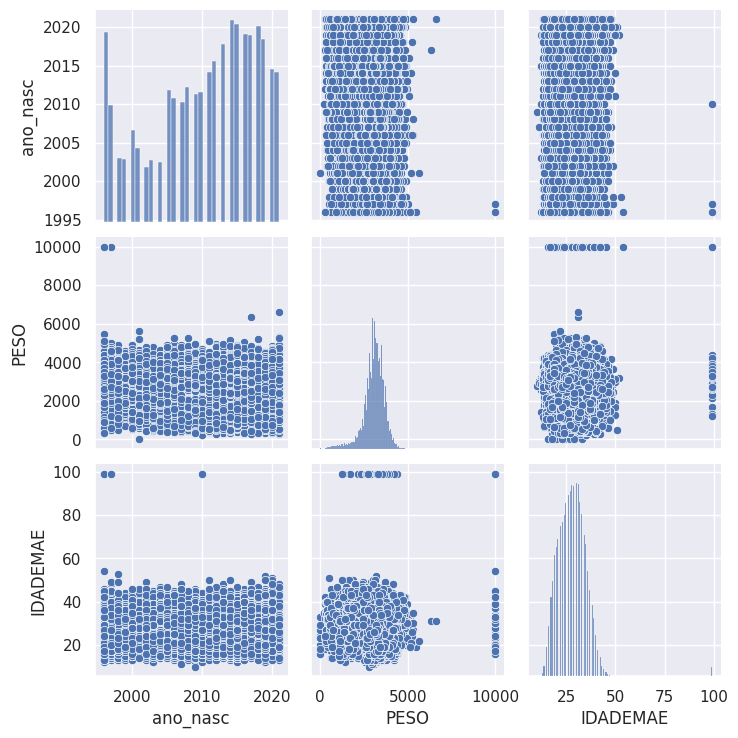

In [ ]:
# Selecionar apenas as colunas desejadas
df_filtered = df_sinasc[['ano_nasc', 'PESO', 'IDADEMAE']]

# Scatter Plot com Seaborn - Variação 1

sns.pairplot(df_filtered)

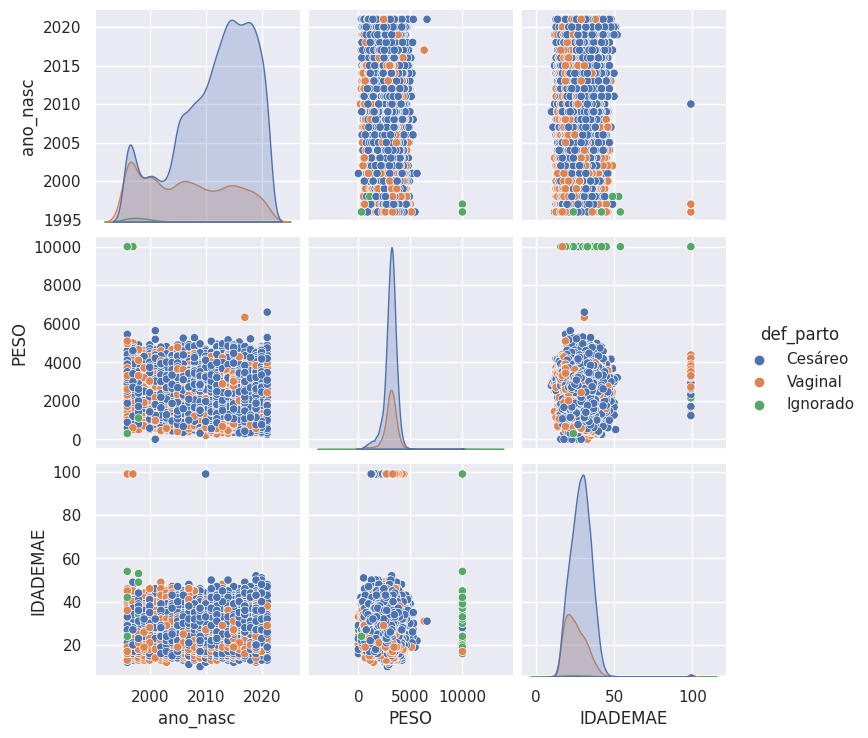

In [ ]:
# Selecionar apenas as colunas desejadas
df_filtered = df_sinasc[['ano_nasc', 'PESO', 'IDADEMAE', 'def_parto']]

# Scatter Plot com Seaborn - Variação 2

sns.pairplot(df_filtered, hue = "def_parto", height = 2.5);

## 4. Pré-Processamento de dados

Nesta etapa, poderíamos realizar diversas operações de preparação de dados, como por exemplo, tratamento de valores missings (faltantes), limpeza de dados, transformações como one-hot-encoding, seleção de características (feature selection), entre outras não mostradas neste notebook. Lembre-se de não criar uma versão padronizada/normalizada dos dados neste momento (apesar de serem operações de pré-processamento) para evitar o Data Leakage.

### 4.1. Tratamento de Missings e Limpeza

Sabemos que o datset Diabetes não tem missings aparentes, mas valores "0" que parecem ser missings. Vamos então fazer este tratamento e criar uma nova visão do nosso dataset.

In [ ]:
# verificando nulls no dataset
df_sinasc.isnull().sum()

nasc_SIGLA_UF          0
res_SIGLA_UF           0
ano_nasc               0
data_nasc           1464
DTNASC                 0
nasc_MUNNOME           0
res_MUNNOME            0
dia_semana_nasc     1464
HORANASC           10547
def_parto              0
def_raca_cor           0
PESO                 151
IDADEMAE              34
IDADEPAI           23493
SEMAGESTAC         19956
CONSPRENAT         21989
MESPRENAT          20112
def_loc_nasc           0
APGAR1              2366
APGAR5              2385
QTDFILVIVO          3103
QTDFILMORT          4526
QTDGESTANT         20103
QTDPARTNOR         20173
QTDPARTCES         20124
dtype: int64

Conforme vimos anteriormente, há dados inconscistentes como um elevado número de parturientes registradas com 99 anos.

In [ ]:
# Conta a quantidade de ocorrências do valor 99 na coluna 'IDADEMAE' do dataframe 'df_sinasc'
qtd_valor_99 = df_sinasc['IDADEMAE'].value_counts().get(99, 0)

# Exibe o resultado
print(f"Quantidade de '99' na coluna 'IDADEMAE': {qtd_valor_99}")

Quantidade de '99' na coluna 'IDADEMAE': 110


Vamos substituir os valores '99' na coluna IDADEMAE pela mediana.

<Axes: >

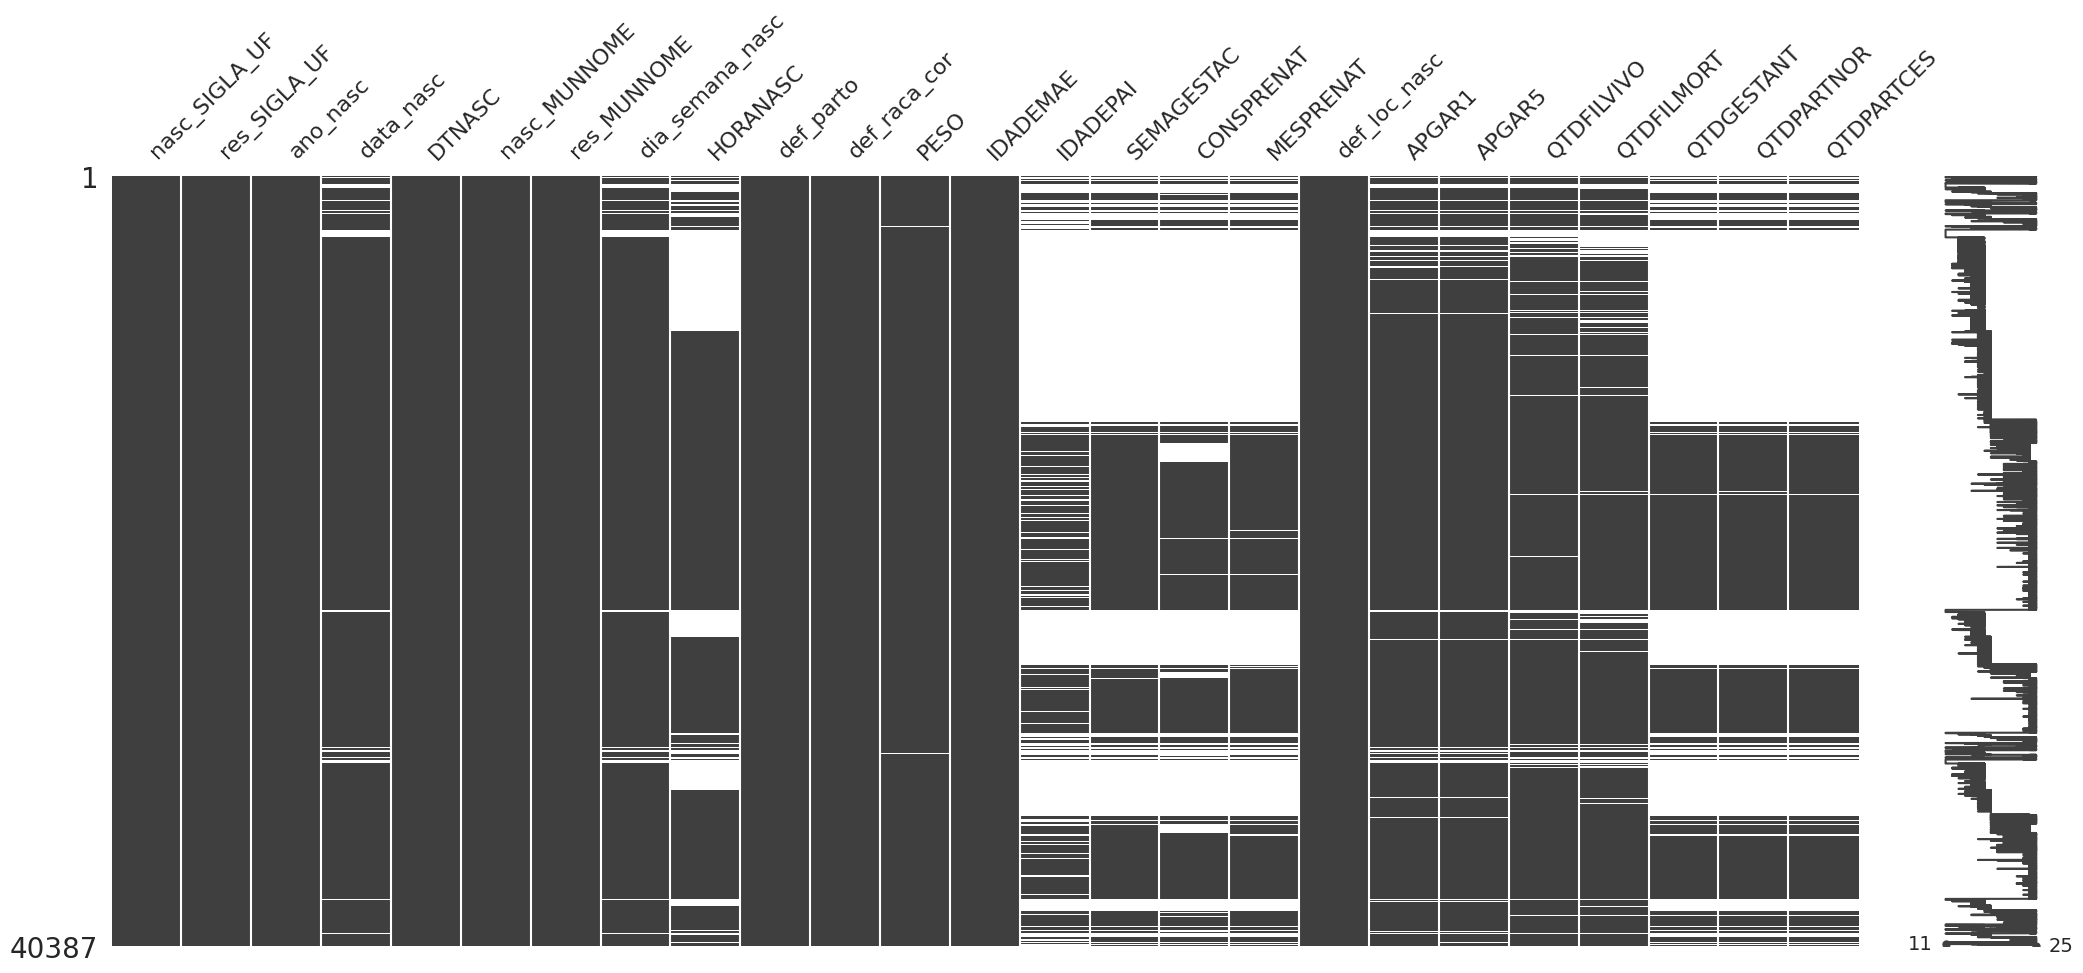

In [ ]:
import missingno as ms

# Criando uma cópia do dataframe original para df_sinasc2
df_sinasc2 = df_sinasc.copy()

# Calculando a mediana da coluna 'IDADEMAE', excluindo os valores '99'
mediana_idademae = df_sinasc2.loc[df_sinasc2['IDADEMAE'] != 99, 'IDADEMAE'].median()

# Substituindo os '99' pela mediana na coluna 'IDADEMAE'
df_sinasc2['IDADEMAE'].replace(99, mediana_idademae, inplace=True)

# Exibindo visualização matricial da nulidade do novo dataframe df_sinasc2
ms.matrix(df_sinasc2)

In [ ]:
# Conta a quantidade de ocorrências do valor 99 na coluna 'IDADEMAE' do dataframe 'df_sinasc'
qtd_valor_99 = df_sinasc2['IDADEMAE'].value_counts().get(99, 0)

# Exibe o resultado
print(f"Quantidade de '99' na coluna 'IDADEMAE': {qtd_valor_99}")

Quantidade de '99' na coluna 'IDADEMAE': 0


In [ ]:
# Verifica a distribuição das classes
df_sinasc2.groupby('IDADEMAE').size()

IDADEMAE
10.0       1
11.0       2
12.0       7
13.0      34
14.0     119
15.0     337
16.0     579
17.0     917
18.0    1102
19.0    1411
20.0    1495
21.0    1589
22.0    1738
23.0    1791
24.0    1870
25.0    2007
26.0    2097
27.0    2147
28.0    2325
29.0    2205
30.0    2239
31.0    2235
32.0    2019
33.0    1888
34.0    1643
35.0    1533
36.0    1217
37.0    1001
38.0     821
39.0     676
40.0     474
41.0     306
42.0     221
43.0     117
44.0      81
45.0      51
46.0      26
47.0      10
48.0       7
49.0       4
50.0       7
51.0       1
52.0       1
53.0       1
54.0       1
dtype: int64

<Axes: >

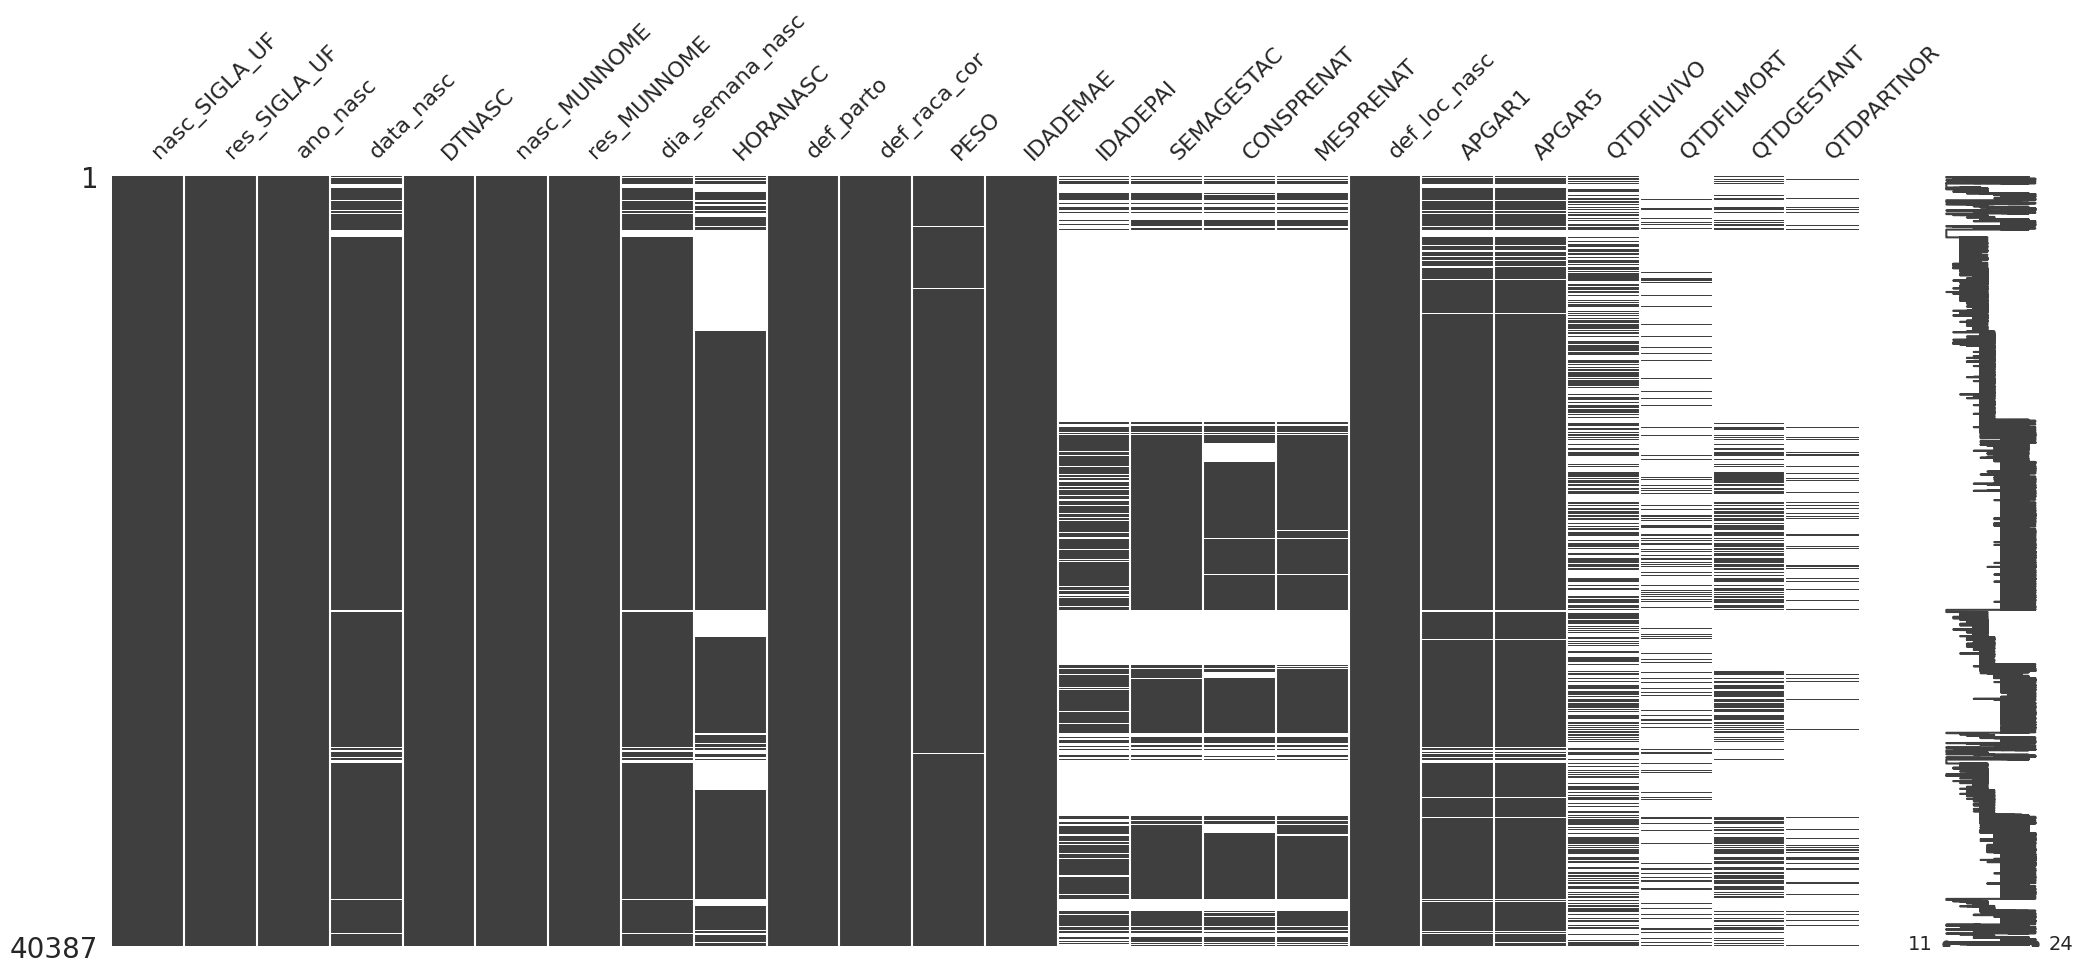

In [ ]:
# salvando um NOVO dataset para tratamento de missings (cuidado para não sobrescrever o dataset original!)

# recuperando os nomes das colunas
col = list(df_sinasc.columns)

# o novo dataset irá conter todas as colunas com exceção da última (classe)
atributos = df_sinasc[col[0:-1]]

# substituindo os zeros por NaN
atributos.replace(0, np.nan, inplace=True)

# exibindo visualização matricial da nulidade do dataset
ms.matrix(atributos)

<Axes: >

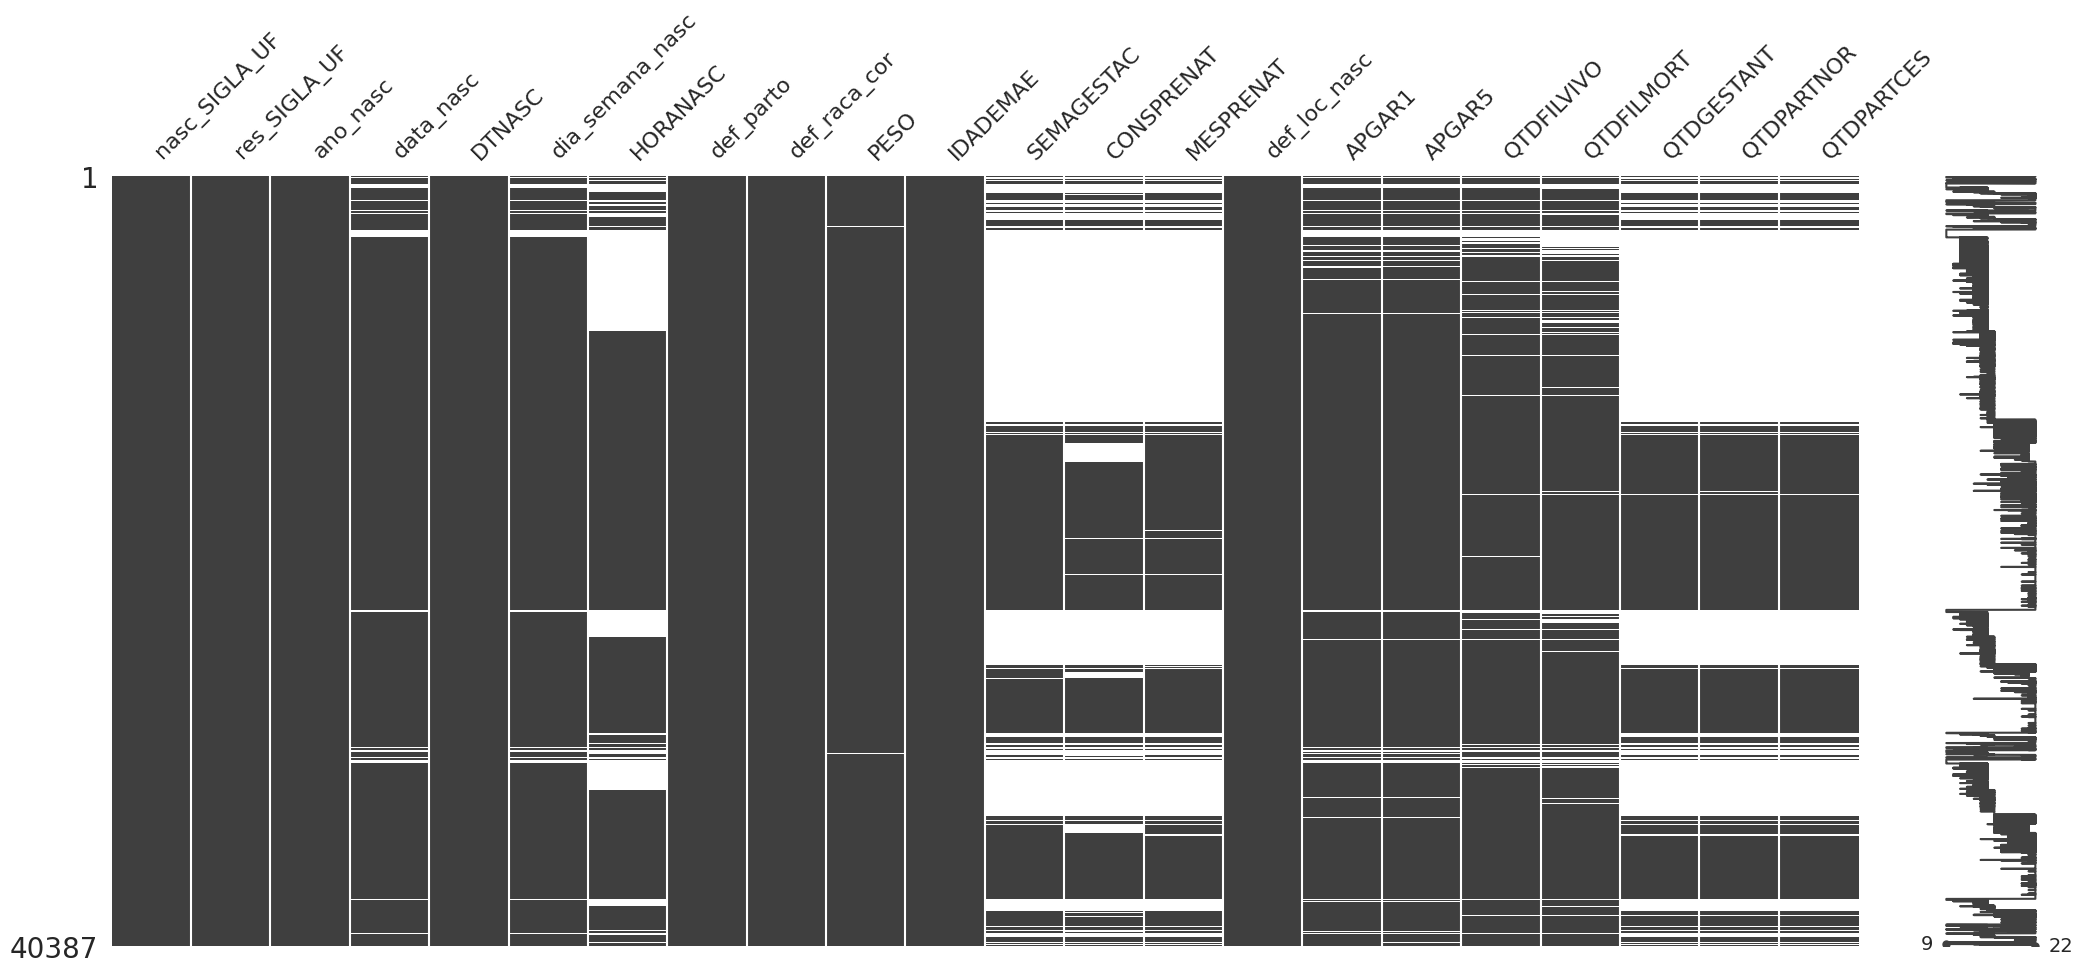

In [ ]:
# removendo as colunas 'IDADEPAI', 'nasc_MUNNOME' e 'res_MUNNOME'
df_sinasc2.drop(['IDADEPAI', 'nasc_MUNNOME', 'res_MUNNOME'], axis=1, inplace= True)

# exibindo visualização matricial da nulidade do dataset
ms.matrix(df_sinasc2)

In [ ]:
# eliminando linhas que tenham ALGUM valor missing

df_sinasc3 = df_sinasc2.dropna(how='any')
df_sinasc3.tail()

,nasc_SIGLA_UF,res_SIGLA_UF,ano_nasc,data_nasc,DTNASC,dia_semana_nasc,HORANASC,def_parto,def_raca_cor,PESO,...,CONSPRENAT,MESPRENAT,def_loc_nasc,APGAR1,APGAR5,QTDFILVIVO,QTDFILMORT,QTDGESTANT,QTDPARTNOR,QTDPARTCES
40382,SP,TO,2021,2021-01-01T00:00:00.000Z,01012021,sex,1403,Cesáreo,Parda,1755.0,...,5.0,1.0,Hospital,03,04,1.0,0.0,1.0,0.0,1.0
40383,SP,TO,2021,2021-02-18T00:00:00.000Z,18022021,qui,1857,Cesáreo,Branca,1400.0,...,10.0,1.0,Hospital,05,09,0.0,1.0,1.0,0.0,0.0
40384,SP,TO,2021,2021-09-18T00:00:00.000Z,18092021,sab,1106,Cesáreo,Branca,2860.0,...,3.0,7.0,Hospital,09,10,0.0,0.0,0.0,0.0,0.0
40385,SP,TO,2021,2021-10-13T00:00:00.000Z,13102021,qua,1213,Cesáreo,Branca,3070.0,...,15.0,1.0,Hospital,09,10,1.0,0.0,1.0,0.0,1.0
40386,SP,TO,2021,2021-10-30T00:00:00.000Z,30102021,sab,1842,Vaginal,Preta,2425.0,...,9.0,2.0,Hospital,01,06,0.0,0.0,0.0,0.0,0.0


Após a remoção das linhas com algum valor de missing, sobram 17.932 partos.

In [ ]:
print(df_sinasc3.shape)

(17933, 22)


### 4.3. Separação em conjunto de treino e conjunto de teste

É uma boa prática usar um conjunto de teste (na literatura também chamado de conjunto de validação), uma amostra dos dados que não será usada para a construção do modelo, mas somente no fim do projeto para confirmar a precisão do modelo final. É um teste que podemos usar para verificar o quão boa foi a construção do modelo, e para nos dar uma ideia de como o modelo irá performar nas estimativas em dados não vistos. Usaremos 80% do conjunto de dados para modelagem e guardaremos 20% para teste, usando a estratégia train-test-split, já explicada anteriormente. Primeiramente, iremos sinalizar quais são as colunas de atributos (X - 0 a 7) e qual é a coluna das classes (Y - 8). Em seguida, especificaremos o tamanho do conjunto de teste desejado e uma semente (para garantir a reprodutibilidade dos resultados). Finalmente, faremos a separação dos conjuntos de treino e teste através do comando train_test_split, que retornará 4 estruturas de dados: os atributos e classes para o conjunto de teste e os atributos e classes para o conjunto de treino.


In [ ]:
test_size = 0.20
seed = 7

# Separação em conjuntos de treino e teste (dataset original)
array = df_sinasc3.values
X = array[:,0:8]
y = array[:,8]
#X_train, X_test, y_train, y_test = train_test_split(X, y,
#    test_size=test_size, shuffle=True, random_state=seed) # sem estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=seed, stratify=y) # com estratificação

## Conclusão

Neste MVP foi possível verificar que o DATASUS possui dados inconsistentes e de série temporal recente. Os dados verificados relacionados ao tipo de parto por dia da semana demonstram que a comodidade dos obstetras contribui para a realização de cesarianas durante o horário comercial dos dias de semana. Outro ponto de atenção é em relação a crianças negras, pardas e indígenas, que são geradas por mais partos naturais em relação a crianças brancas por conta do menor acesso ao sistema de Saúde por esses segmentos.